In [1]:
from tensorflow import keras
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import sklearn.metrics
import h5py
import pandas as pd
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


2023-02-02 06:54:17.929832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 06:54:17.999851: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TARGET_BYTE = 2 #何バイト目を攻撃するか決める

In [3]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [4]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [5]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [6]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [7]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [8]:
train_trace = train_trace[0:45000, 45400:46100]
test_trace = test_trace[45000:50000, 45400:46100]
attack_trace = attack_trace[50000:60000, 45400:46100]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [9]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [10]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [11]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [12]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [13]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [14]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

2023-02-02 06:54:19.760377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 06:54:19.761600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 06:54:19.761669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 06:54:19.761922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [15]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [16]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [17]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

2023-02-02 06:54:20.953169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-02 06:54:20.954381: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3f886394e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-02 06:54:20.954397: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-02-02 06:54:20.956625: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-02 06:54:21.013332: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 [==============================] - 0s 504us/step
Epoch 1 - GE:21.5028, SR:0.0 last trace rank:12
313/313 [==============================] - 0s 712us/step
Epoch 2 - GE:22.4139, SR:0.0 last trace rank:12
313/313 [==============================] - 0s 524us/step
Epoch 3 - GE:23.7857, SR:0.0 last trace rank:12
313/313 [==============================] - 0s 509us/step
Epoch 4 - GE:25.204775, SR:0.0 last trace rank:9
313/313 [==============================] - 0s 522us/step
Epoch 5 - GE:25.718, SR:0.0 last trace rank:10
313/313 [==============================] - 0s 635us/step
Epoch 6 - GE:26.613933333333332, SR:0.0 last trace rank:10
313/313 [==============================] - 0s 535us/step
Epoch 7 - GE:27.531785714285714, SR:0.0 last trace rank:12
313/313 [==============================] - 0s 598us/step
Epoch 8 - GE:28.4358, SR:0.0 last trace rank:10
313/313 [==============================] - 0s 725us/step
Epoch 9 - GE:29.018988888888888, SR:0.0 last trace rank:13
313/313 [=============

Text(0.5, 1.0, 'target_2byte')

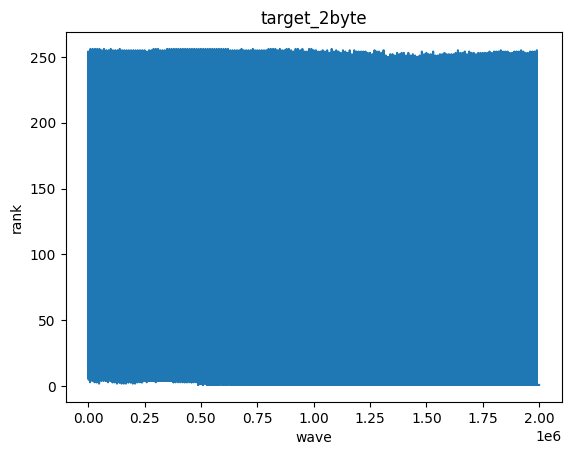

In [18]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

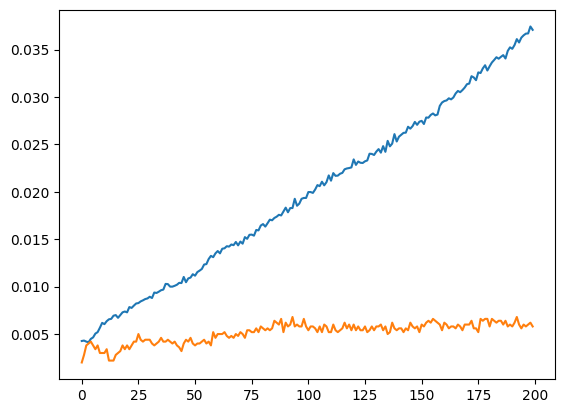

In [19]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [20]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 629us/step


TensorShape([10000, 256])

In [21]:
attack_plain=attack_metadata['plaintext']

In [22]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [23]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [24]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_2byte')

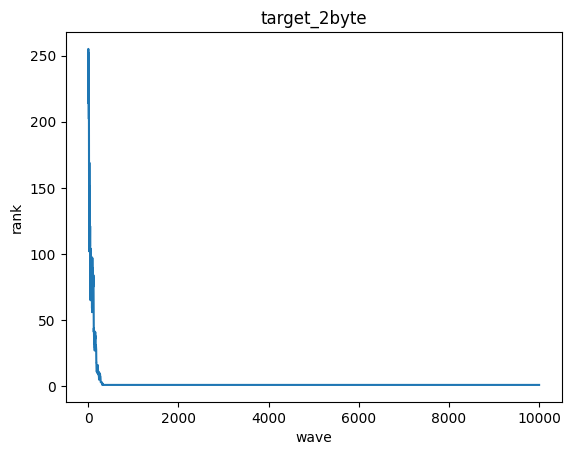

In [25]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [26]:
TARGET_BYTE = 3 #何バイト目を攻撃するか決める

In [27]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [28]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [29]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [30]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [31]:
train_trace = train_trace[0:45000, 32906:33606]
test_trace = test_trace[45000:50000, 32906:33606]
attack_trace = attack_trace[50000:60000, 32906:33606]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [32]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [33]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [34]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [35]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [36]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [37]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [38]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [39]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [40]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 0s 1ms/step
Epoch 1 - GE:115.4664, SR:0.0002 last trace rank:170
313/313 [==============================] - 0s 538us/step
Epoch 2 - GE:102.7903, SR:0.0002 last trace rank:133
313/313 [==============================] - 0s 544us/step
Epoch 3 - GE:90.4721, SR:0.0002 last trace rank:111
313/313 [==============================] - 0s 609us/step
Epoch 4 - GE:81.3083, SR:0.000325 last trace rank:89
313/313 [==============================] - 0s 516us/step
Epoch 5 - GE:72.59092, SR:0.00034 last trace rank:62
313/313 [==============================] - 0s 603us/step
Epoch 6 - GE:65.55856666666666, SR:0.00031666666666666665 last trace rank:47
313/313 [==============================] - 0s 750us/step
Epoch 7 - GE:59.369285714285716, SR:0.0003 last trace rank:37
313/313 [==============================] - 0s 548us/step
Epoch 8 - GE:54.6381375, SR:0.000275 last trace rank:31
313/313 [==============================] - 0s 637us/step
Epoch 9 - GE:50.72138888888889

Text(0.5, 1.0, 'target_3byte')

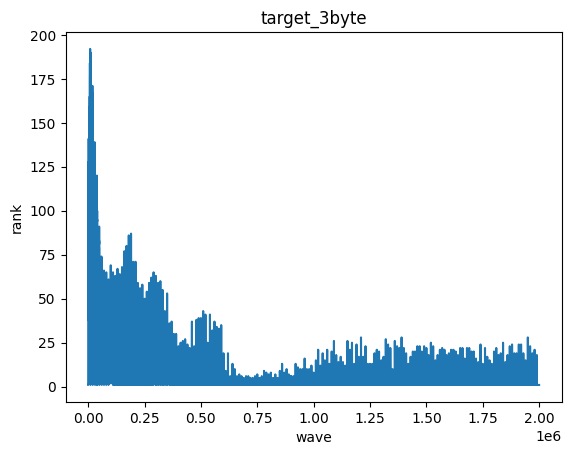

In [41]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

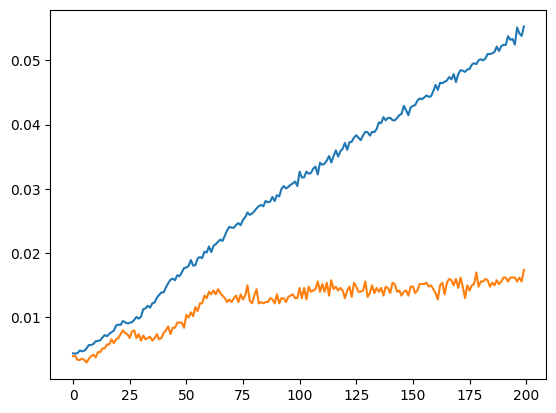

In [42]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [43]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 525us/step


TensorShape([10000, 256])

In [44]:
attack_plain=attack_metadata['plaintext']

In [45]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [46]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [47]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_3byte')

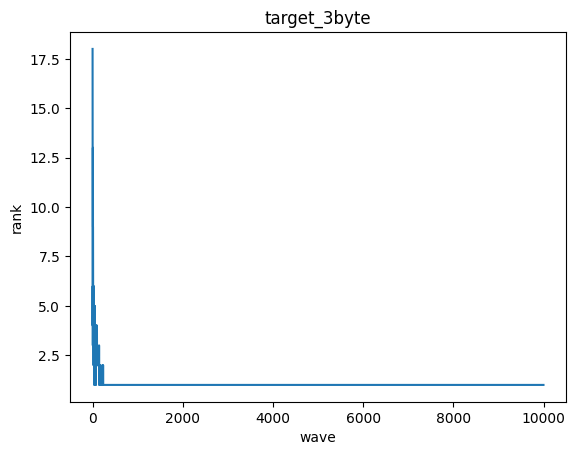

In [48]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [49]:
TARGET_BYTE = 4 #何バイト目を攻撃するか決める

In [50]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [51]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [52]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [53]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [54]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [55]:
train_trace = train_trace[0:45000, 47482:48182]
test_trace = test_trace[45000:50000, 47482:48182]
attack_trace = attack_trace[50000:60000, 47482:48182]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [56]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [57]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [58]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [59]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [60]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [61]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [62]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [63]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [64]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 0s 515us/step
Epoch 1 - GE:32.0812, SR:0.3043 last trace rank:1
313/313 [==============================] - 0s 569us/step
Epoch 2 - GE:29.0973, SR:0.25155 last trace rank:1
313/313 [==============================] - 0s 561us/step
Epoch 3 - GE:27.077933333333334, SR:0.20403333333333334 last trace rank:2
313/313 [==============================] - 0s 587us/step
Epoch 4 - GE:25.927625, SR:0.1717 last trace rank:2
313/313 [==============================] - 0s 728us/step
Epoch 5 - GE:24.59784, SR:0.1612 last trace rank:2
313/313 [==============================] - 0s 506us/step
Epoch 6 - GE:23.703833333333332, SR:0.14156666666666667 last trace rank:2
313/313 [==============================] - 0s 557us/step
Epoch 7 - GE:23.298671428571428, SR:0.12315714285714285 last trace rank:2
313/313 [==============================] - 0s 889us/step
Epoch 8 - GE:22.6743875, SR:0.1113625 last trace rank:2
313/313 [==============================] - 0s 608us/step
Epoch

Text(0.5, 1.0, 'target_4byte')

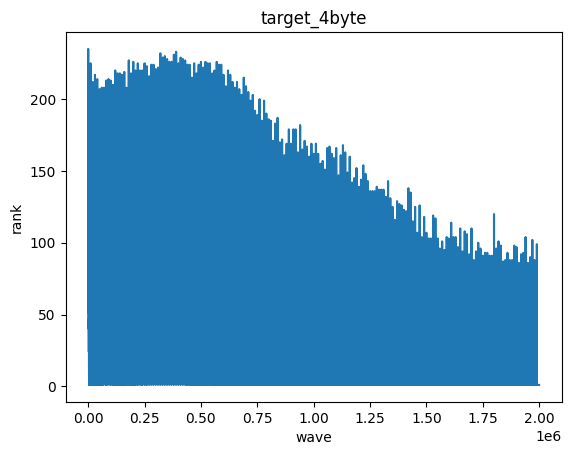

In [65]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

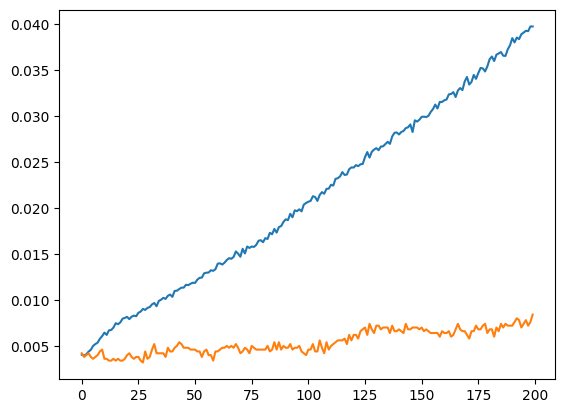

In [66]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [67]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 0s 1ms/step


TensorShape([10000, 256])

In [68]:
attack_plain=attack_metadata['plaintext']

In [69]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [70]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [71]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_4byte')

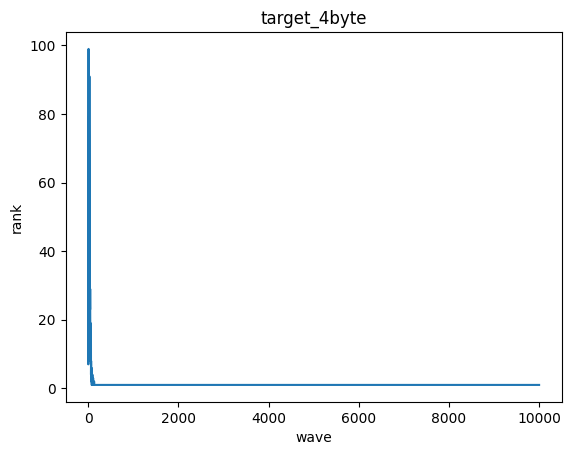

In [72]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [73]:
TARGET_BYTE = 5 #何バイト目を攻撃するか決める

In [74]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [75]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [76]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [77]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [78]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [79]:
train_trace = train_trace[0:45000, 41235:41935]
test_trace = test_trace[45000:50000, 41235:41935]
attack_trace = attack_trace[50000:60000, 41235:41935]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [80]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [81]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [82]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [83]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [84]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [85]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [86]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [87]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [88]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 0s 529us/step
Epoch 1 - GE:68.4603, SR:0.0 last trace rank:49
313/313 [==============================] - 0s 1ms/step
Epoch 2 - GE:68.7945, SR:0.0 last trace rank:43
313/313 [==============================] - 0s 505us/step
Epoch 3 - GE:68.8085, SR:0.0 last trace rank:39
313/313 [==============================] - 0s 531us/step
Epoch 4 - GE:67.238975, SR:0.0 last trace rank:34
313/313 [==============================] - 0s 518us/step
Epoch 5 - GE:65.03216, SR:0.0 last trace rank:29
313/313 [==============================] - 0s 610us/step
Epoch 6 - GE:63.37361666666666, SR:0.0 last trace rank:30
313/313 [==============================] - 0s 575us/step
Epoch 7 - GE:60.711957142857145, SR:0.0 last trace rank:23
313/313 [==============================] - 0s 521us/step
Epoch 8 - GE:58.126025, SR:0.0 last trace rank:18
313/313 [==============================] - 0s 541us/step
Epoch 9 - GE:55.2458, SR:0.0 last trace rank:13
313/313 [======================

KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 6 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 37071:37771]
test_trace = test_trace[45000:50000, 37071:37771]
attack_trace = attack_trace[50000:60000, 37071:37771]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 7 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 34989:35689]
test_trace = test_trace[45000:50000, 34989:35689]
attack_trace = attack_trace[50000:60000, 34989:35689]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 8 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 26660:27360]
test_trace = test_trace[45000:50000, 26660:27360]
attack_trace = attack_trace[50000:60000, 26660:27360]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 9 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 39154:39854]
test_trace = test_trace[45000:50000, 39154:39854]
attack_trace = attack_trace[50000:60000, 39154:39854]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 10 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 28742:29442]
test_trace = test_trace[45000:50000, 28742:29442]
attack_trace = attack_trace[50000:60000, 28742:29442]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 11 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 43318:44018]
test_trace = test_trace[45000:50000, 43318:44018]
attack_trace = attack_trace[50000:60000, 43318:44018]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 12 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 20413:21113]
test_trace = test_trace[45000:50000, 20413:21113]
attack_trace = attack_trace[50000:60000, 20413:21113]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 13 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 22495:23195]
test_trace = test_trace[45000:50000, 22495:23195]
attack_trace = attack_trace[50000:60000, 22495:23195]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 14 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 49565:50265]
test_trace = test_trace[45000:50000, 49565:50265]
attack_trace = attack_trace[50000:60000, 49565:50265]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
TARGET_BYTE = 15 #何バイト目を攻撃するか決める

In [ ]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [ ]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [ ]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [ ]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

In [ ]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [ ]:
train_trace = train_trace[0:45000, 18330:19030]
test_trace = test_trace[45000:50000, 18330:19030]
attack_trace = attack_trace[50000:60000, 18330:19030]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

In [ ]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [ ]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [ ]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [ ]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [ ]:
def mlp_best(node=200,layer_nb=6,input_dim=700):
	model = Sequential()
	model.add(Dense(node, input_dim=input_dim, activation='relu'))
	for i in range(layer_nb-2):
		model.add(Dense(node, activation='relu'))
	model.add(Dense(256))
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [ ]:
mlp_best()
model=mlp_best(node=200,layer_nb=6,input_dim=700)

In [ ]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [ ]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [ ]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=100,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

In [ ]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [ ]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

In [ ]:
attack_plain=attack_metadata['plaintext']

In [ ]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [ ]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [ ]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

In [ ]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))